# 付録A12: 三者閉包（Triadic Closure）

## 学習目標

この付録では、ネットワーク科学における重要な概念「三者閉包」について学びます。

- 三者閉包の定義と社会的意味を理解する
- クラスタリング係数と推移性を測定する
- 三者閉包に基づくネットワーク進化をシミュレーションする
- トライアドセンサス（triad census）で有向グラフを分析する

## セットアップ

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict, Counter
from itertools import combinations
import japanize_matplotlib

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['IPAexGothic'] + plt.rcParams['font.sans-serif']
plt.rcParams['figure.figsize'] = (10, 6)

# 再現性のための乱数シード
np.random.seed(42)
random.seed(42)

## A12.1 三者閉包とは

### 概念の定義

**三者閉包（Triadic Closure）** とは、「友達の友達は友達になりやすい」という社会ネットワークの普遍的な傾向です。

### 開いたトライアドと閉じたトライアド

- **開いたトライアド（Open Triad）**: A-B、B-Cは接続されているが、A-Cは接続されていない
- **閉じたトライアド（Closed Triad）**: A-B、B-C、A-Cすべてが接続されている（三角形）

### なぜ三者閉包が起こるのか

1. **機会（Opportunity）**: 共通の友人を通じて出会う機会が増える
2. **信頼（Trust）**: 共通の友人がいると信頼が生まれやすい
3. **類似性（Similarity）**: 同じ人と友人なら似た属性を持つ可能性が高い

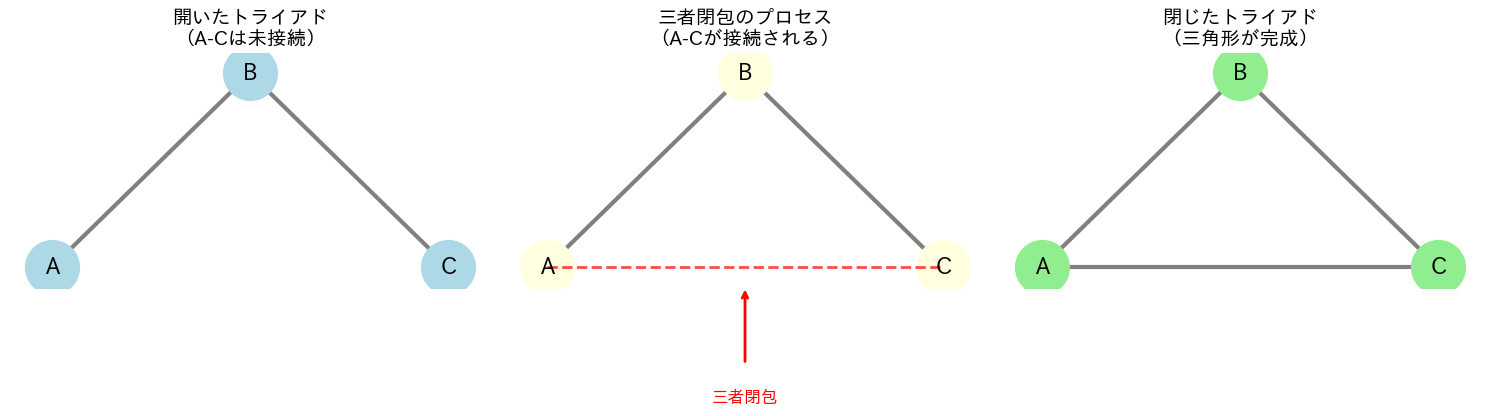

三者閉包の原理:
  AとBが友人、BとCが友人 → AとCも友人になりやすい
  
社会学的説明:
  - 共通の友人を通じて出会う機会
  - 共通の友人による信頼の担保
  - 類似した属性を持つ可能性


In [2]:
# 三者閉包の視覚的説明
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 開いたトライアド
G_open = nx.Graph()
G_open.add_edges_from([('A', 'B'), ('B', 'C')])
pos_open = {'A': (0, 0), 'B': (1, 1), 'C': (2, 0)}

nx.draw(G_open, pos_open, ax=axes[0], with_labels=True,
        node_color='lightblue', node_size=1500, font_size=16,
        edge_color='gray', width=3)
axes[0].set_title('開いたトライアド\n（A-Cは未接続）', fontsize=14)

# 三者閉包のプロセス
G_closing = nx.Graph()
G_closing.add_edges_from([('A', 'B'), ('B', 'C')])
pos_closing = {'A': (0, 0), 'B': (1, 1), 'C': (2, 0)}

nx.draw(G_closing, pos_closing, ax=axes[1], with_labels=True,
        node_color='lightyellow', node_size=1500, font_size=16,
        edge_color='gray', width=3)
# 点線で閉包を示す
axes[1].plot([0, 2], [0, 0], 'r--', linewidth=2, alpha=0.7)
axes[1].annotate('', xy=(1, -0.1), xytext=(1, -0.5),
                arrowprops=dict(arrowstyle='->', color='red', lw=2))
axes[1].text(1, -0.7, '三者閉包', fontsize=12, ha='center', color='red')
axes[1].set_title('三者閉包のプロセス\n（A-Cが接続される）', fontsize=14)

# 閉じたトライアド（三角形）
G_closed = nx.Graph()
G_closed.add_edges_from([('A', 'B'), ('B', 'C'), ('A', 'C')])
pos_closed = {'A': (0, 0), 'B': (1, 1), 'C': (2, 0)}

nx.draw(G_closed, pos_closed, ax=axes[2], with_labels=True,
        node_color='lightgreen', node_size=1500, font_size=16,
        edge_color='gray', width=3)
axes[2].set_title('閉じたトライアド\n（三角形が完成）', fontsize=14)

plt.tight_layout()
plt.show()

print("三者閉包の原理:")
print("  AとBが友人、BとCが友人 → AとCも友人になりやすい")
print("  \n社会学的説明:")
print("  - 共通の友人を通じて出会う機会")
print("  - 共通の友人による信頼の担保")
print("  - 類似した属性を持つ可能性")

## A12.2 クラスタリング係数

### ローカルクラスタリング係数

ノードvのローカルクラスタリング係数は、vの隣接ノード間のエッジ密度を測定します：

$$C_v = \frac{2 \cdot |\{e_{jk}\}|}{k_v(k_v - 1)}$$

- $k_v$: ノードvの次数
- $|\{e_{jk}\}|$: vの隣接ノード間のエッジ数

### グローバルクラスタリング係数（推移性）

ネットワーク全体での三角形の密度：

$$C = \frac{3 \times \text{三角形の数}}{\text{連結トリプルの数}}$$

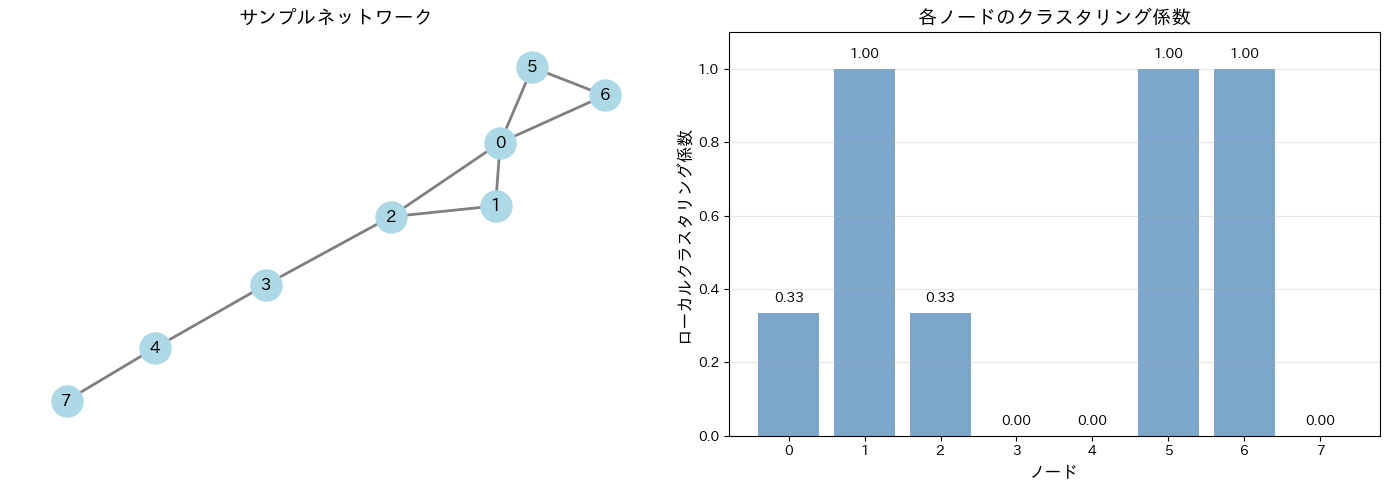

ネットワーク統計:
  三角形の数: 2
  開いたトライアドの数: 8
  連結トリプルの数: 14

クラスタリング指標:
  平均クラスタリング係数: 0.4583
  推移性（グローバル）: 0.4286


In [3]:
def count_triads(G):
    """
    開いたトライアドと閉じたトライアドの数を数える
    """
    triangles = sum(nx.triangles(G).values()) // 3
    
    # 連結トリプル（パス長2）の数
    connected_triples = 0
    for node in G.nodes():
        degree = G.degree(node)
        connected_triples += degree * (degree - 1) // 2
    
    open_triads = connected_triples - 3 * triangles
    
    return triangles, open_triads, connected_triples

# 例: 小さなネットワークでの計算
G_example = nx.Graph()
G_example.add_edges_from([
    (0, 1), (1, 2), (2, 0),  # 三角形
    (2, 3), (3, 4),          # パス
    (0, 5), (5, 6), (6, 0),  # 三角形
    (4, 7)                   # 追加エッジ
])

triangles, open_triads, connected_triples = count_triads(G_example)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ネットワークの可視化
pos = nx.spring_layout(G_example, seed=42)
nx.draw(G_example, pos, ax=axes[0], with_labels=True,
        node_color='lightblue', node_size=500, font_size=12,
        edge_color='gray', width=2)
axes[0].set_title('サンプルネットワーク', fontsize=14)

# クラスタリング係数の分布
clustering_coeffs = list(nx.clustering(G_example).values())
nodes = list(G_example.nodes())

bars = axes[1].bar(nodes, clustering_coeffs, color='steelblue', alpha=0.7)
axes[1].set_xlabel('ノード', fontsize=12)
axes[1].set_ylabel('ローカルクラスタリング係数', fontsize=12)
axes[1].set_title('各ノードのクラスタリング係数', fontsize=14)
axes[1].set_ylim(0, 1.1)
axes[1].grid(True, alpha=0.3, axis='y')

# 値をバーの上に表示
for bar, coef in zip(bars, clustering_coeffs):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03,
                f'{coef:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# 統計情報
avg_clustering = nx.average_clustering(G_example)
transitivity = nx.transitivity(G_example)

print(f"ネットワーク統計:")
print(f"  三角形の数: {triangles}")
print(f"  開いたトライアドの数: {open_triads}")
print(f"  連結トリプルの数: {connected_triples}")
print(f"\nクラスタリング指標:")
print(f"  平均クラスタリング係数: {avg_clustering:.4f}")
print(f"  推移性（グローバル）: {transitivity:.4f}")

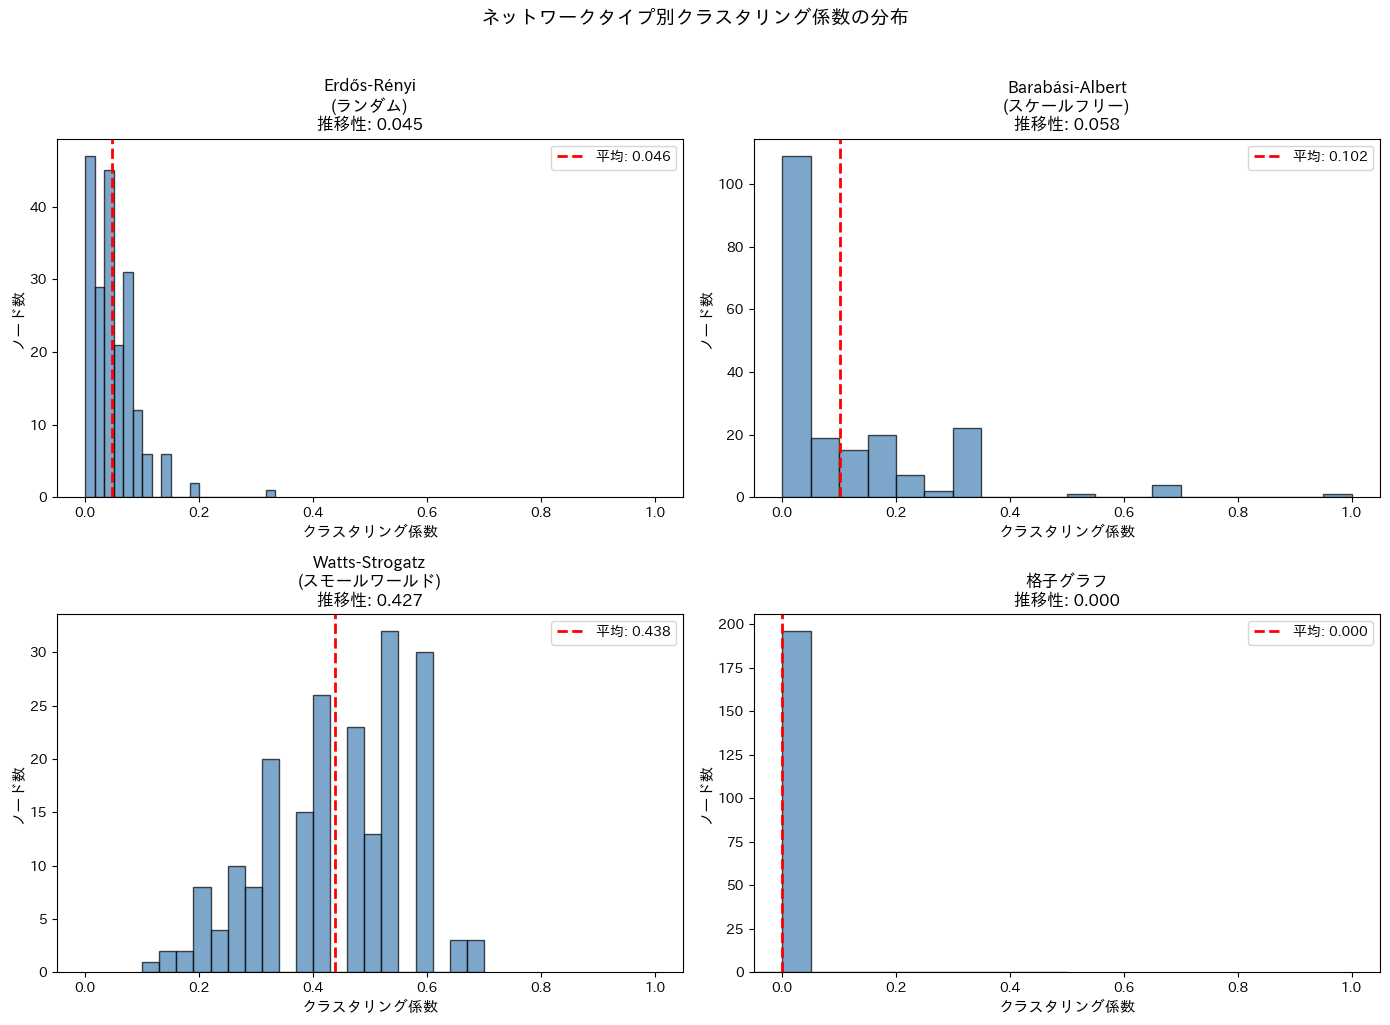

ネットワークタイプ別の統計:
  Erdős-Rényi (ランダム): 平均C=0.046, 推移性=0.045, 三角形=130
  Barabási-Albert (スケールフリー): 平均C=0.102, 推移性=0.058, 三角形=125
  Watts-Strogatz (スモールワールド): 平均C=0.438, 推移性=0.427, 三角形=435
  格子グラフ: 平均C=0.000, 推移性=0.000, 三角形=0


In [4]:
# 異なるネットワークタイプでのクラスタリング比較
n = 200

networks = {
    'Erdős-Rényi\n(ランダム)': nx.erdos_renyi_graph(n, 0.05, seed=42),
    'Barabási-Albert\n(スケールフリー)': nx.barabasi_albert_graph(n, 3, seed=42),
    'Watts-Strogatz\n(スモールワールド)': nx.watts_strogatz_graph(n, 6, 0.1, seed=42),
    '格子グラフ': nx.grid_2d_graph(14, 14),
}

# 格子グラフのノードを整数に変換
networks['格子グラフ'] = nx.convert_node_labels_to_integers(networks['格子グラフ'])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (name, G) in zip(axes, networks.items()):
    # クラスタリング係数の分布
    clustering_values = list(nx.clustering(G).values())
    
    ax.hist(clustering_values, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
    
    avg_c = np.mean(clustering_values)
    trans = nx.transitivity(G)
    
    ax.axvline(avg_c, color='red', linestyle='--', linewidth=2, label=f'平均: {avg_c:.3f}')
    ax.set_xlabel('クラスタリング係数', fontsize=11)
    ax.set_ylabel('ノード数', fontsize=11)
    ax.set_title(f'{name}\n推移性: {trans:.3f}', fontsize=12)
    ax.legend()
    ax.set_xlim(-0.05, 1.05)

plt.suptitle('ネットワークタイプ別クラスタリング係数の分布', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("ネットワークタイプ別の統計:")
for name, G in networks.items():
    avg_c = nx.average_clustering(G)
    trans = nx.transitivity(G)
    triangles = sum(nx.triangles(G).values()) // 3
    print(f"  {name.replace(chr(10), ' ')}: 平均C={avg_c:.3f}, 推移性={trans:.3f}, 三角形={triangles}")

## A12.3 三者閉包の確率

### 閉包率の測定

ある時点で存在する開いたトライアドが、将来閉じる確率を測定します。

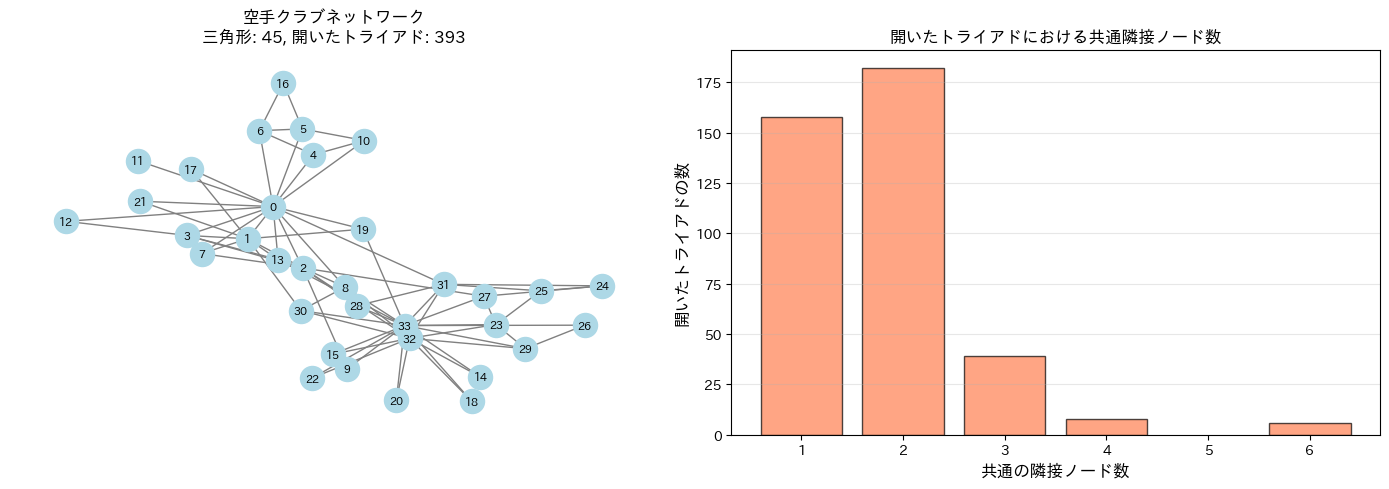

空手クラブネットワークの分析:
  ノード数: 34
  エッジ数: 78
  三角形の数: 45
  開いたトライアドの数: 393
  推移性: 0.2557


In [5]:
def get_open_triads(G):
    """
    すべての開いたトライアドを取得
    返り値: [(center, end1, end2), ...]
    """
    open_triads = []
    
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                if not G.has_edge(n1, n2):
                    open_triads.append((node, n1, n2))
    
    return open_triads

def measure_closure_probability(G, n_samples=100):
    """
    開いたトライアドと閉じたトライアドの統計を計算
    """
    open_triads = get_open_triads(G)
    
    # 共通の隣接ノード数ごとの統計
    common_neighbors_count = defaultdict(int)
    
    for center, n1, n2 in open_triads:
        common = len(set(G.neighbors(n1)) & set(G.neighbors(n2)))
        common_neighbors_count[common] += 1
    
    return open_triads, common_neighbors_count

# 実際のネットワークで分析
G = nx.karate_club_graph()

open_triads, common_count = measure_closure_probability(G)
triangles = sum(nx.triangles(G).values()) // 3

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ネットワーク可視化
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, ax=axes[0], with_labels=True,
        node_color='lightblue', node_size=300, font_size=8,
        edge_color='gray', width=1)
axes[0].set_title(f'空手クラブネットワーク\n三角形: {triangles}, 開いたトライアド: {len(open_triads)}', fontsize=12)

# 共通隣接ノード数の分布
x = sorted(common_count.keys())
y = [common_count[k] for k in x]

axes[1].bar(x, y, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('共通の隣接ノード数', fontsize=12)
axes[1].set_ylabel('開いたトライアドの数', fontsize=12)
axes[1].set_title('開いたトライアドにおける共通隣接ノード数', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"空手クラブネットワークの分析:")
print(f"  ノード数: {G.number_of_nodes()}")
print(f"  エッジ数: {G.number_of_edges()}")
print(f"  三角形の数: {triangles}")
print(f"  開いたトライアドの数: {len(open_triads)}")
print(f"  推移性: {nx.transitivity(G):.4f}")

## A12.4 三者閉包によるネットワーク進化

### シミュレーションモデル

三者閉包に基づくネットワーク成長をシミュレーションします。

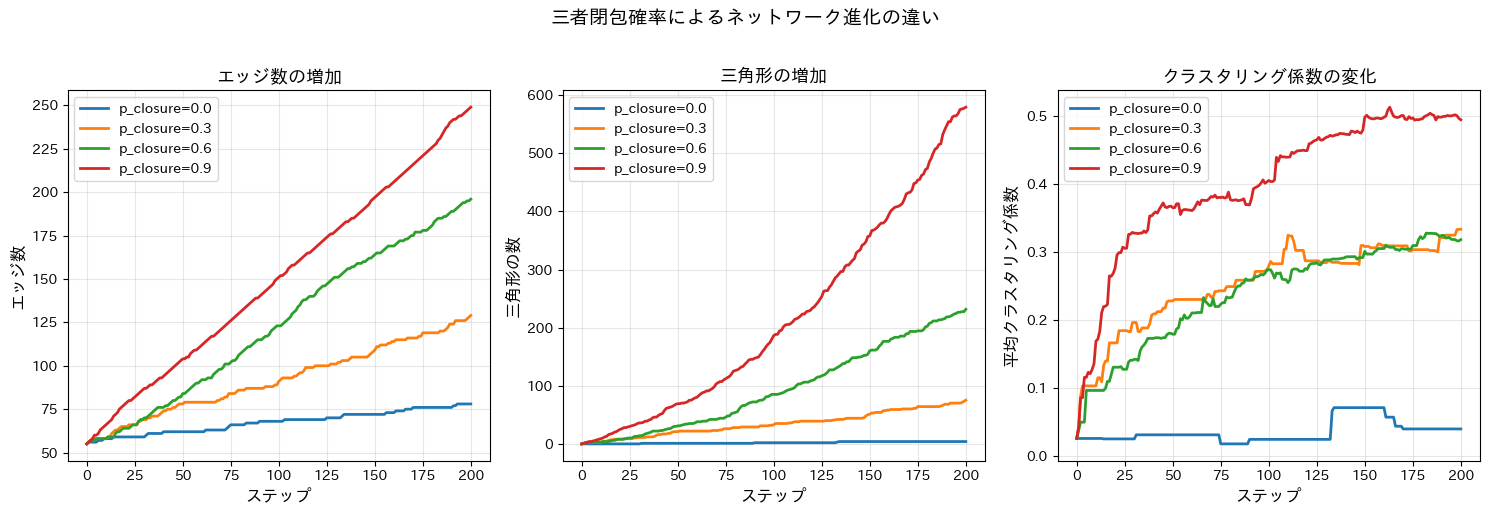

In [6]:
def evolve_with_triadic_closure(G, n_steps, p_closure=0.5, p_random=0.1):
    """
    三者閉包に基づくネットワーク進化
    
    Parameters:
    -----------
    G : networkx.Graph
        初期ネットワーク
    n_steps : int
        進化ステップ数
    p_closure : float
        三者閉包の確率
    p_random : float
        ランダム接続の確率
    """
    G = G.copy()
    history = {
        'edges': [G.number_of_edges()],
        'triangles': [sum(nx.triangles(G).values()) // 3],
        'clustering': [nx.average_clustering(G)]
    }
    
    for step in range(n_steps):
        # 開いたトライアドを取得
        open_triads = get_open_triads(G)
        
        if open_triads and random.random() < p_closure:
            # 三者閉包：ランダムに開いたトライアドを選んで閉じる
            center, n1, n2 = random.choice(open_triads)
            G.add_edge(n1, n2)
        
        if random.random() < p_random:
            # ランダム接続：未接続のノードペアを接続
            nodes = list(G.nodes())
            attempts = 0
            while attempts < 10:
                n1, n2 = random.sample(nodes, 2)
                if not G.has_edge(n1, n2):
                    G.add_edge(n1, n2)
                    break
                attempts += 1
        
        history['edges'].append(G.number_of_edges())
        history['triangles'].append(sum(nx.triangles(G).values()) // 3)
        history['clustering'].append(nx.average_clustering(G))
    
    return G, history

# 初期ネットワーク（スパース）
G_init = nx.erdos_renyi_graph(50, 0.05, seed=42)

# 異なる閉包確率で進化
p_closures = [0.0, 0.3, 0.6, 0.9]
n_steps = 200

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for p_closure in p_closures:
    _, history = evolve_with_triadic_closure(G_init.copy(), n_steps, 
                                              p_closure=p_closure, p_random=0.1)
    
    axes[0].plot(history['edges'], label=f'p_closure={p_closure}', linewidth=2)
    axes[1].plot(history['triangles'], label=f'p_closure={p_closure}', linewidth=2)
    axes[2].plot(history['clustering'], label=f'p_closure={p_closure}', linewidth=2)

axes[0].set_xlabel('ステップ', fontsize=12)
axes[0].set_ylabel('エッジ数', fontsize=12)
axes[0].set_title('エッジ数の増加', fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('ステップ', fontsize=12)
axes[1].set_ylabel('三角形の数', fontsize=12)
axes[1].set_title('三角形の増加', fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].set_xlabel('ステップ', fontsize=12)
axes[2].set_ylabel('平均クラスタリング係数', fontsize=12)
axes[2].set_title('クラスタリング係数の変化', fontsize=13)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('三者閉包確率によるネットワーク進化の違い', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

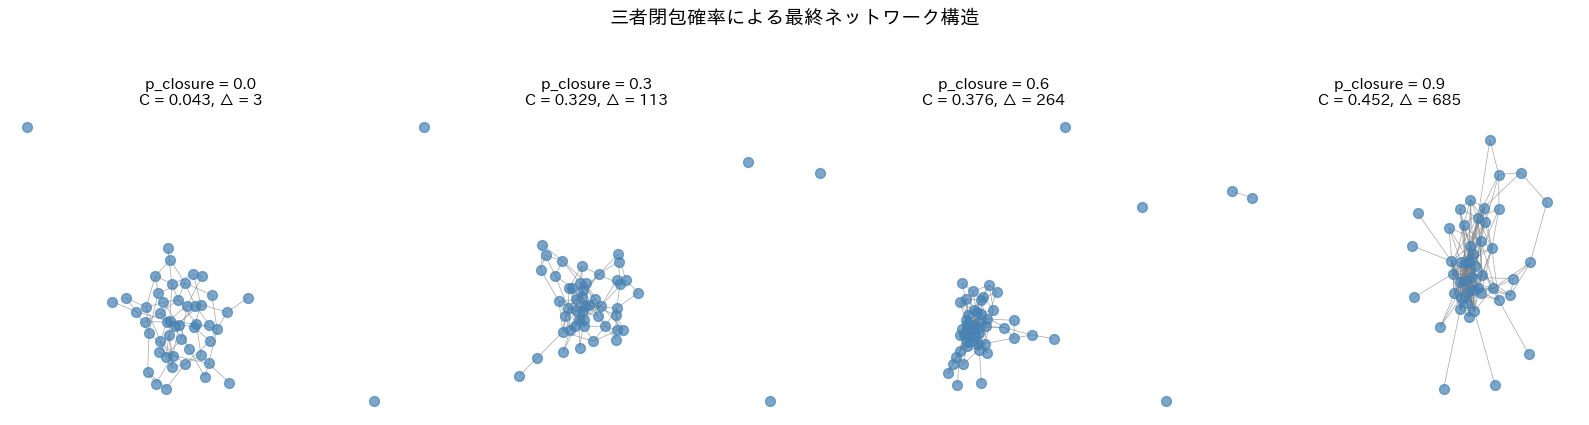

In [7]:
# 進化後のネットワーク構造の比較
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, p_closure in zip(axes, p_closures):
    G_evolved, _ = evolve_with_triadic_closure(G_init.copy(), n_steps,
                                                p_closure=p_closure, p_random=0.1)
    
    pos = nx.spring_layout(G_evolved, seed=42)
    nx.draw(G_evolved, pos, ax=ax, node_size=50,
            node_color='steelblue', edge_color='gray', alpha=0.7, width=0.5)
    
    clustering = nx.average_clustering(G_evolved)
    triangles = sum(nx.triangles(G_evolved).values()) // 3
    
    ax.set_title(f'p_closure = {p_closure}\nC = {clustering:.3f}, △ = {triangles}', fontsize=11)

plt.suptitle('三者閉包確率による最終ネットワーク構造', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

## A12.5 トライアドセンサス（有向グラフ）

### 16種類のトライアド

有向グラフでは、3つのノード間の関係パターンは16種類に分類されます（MAN記法）。

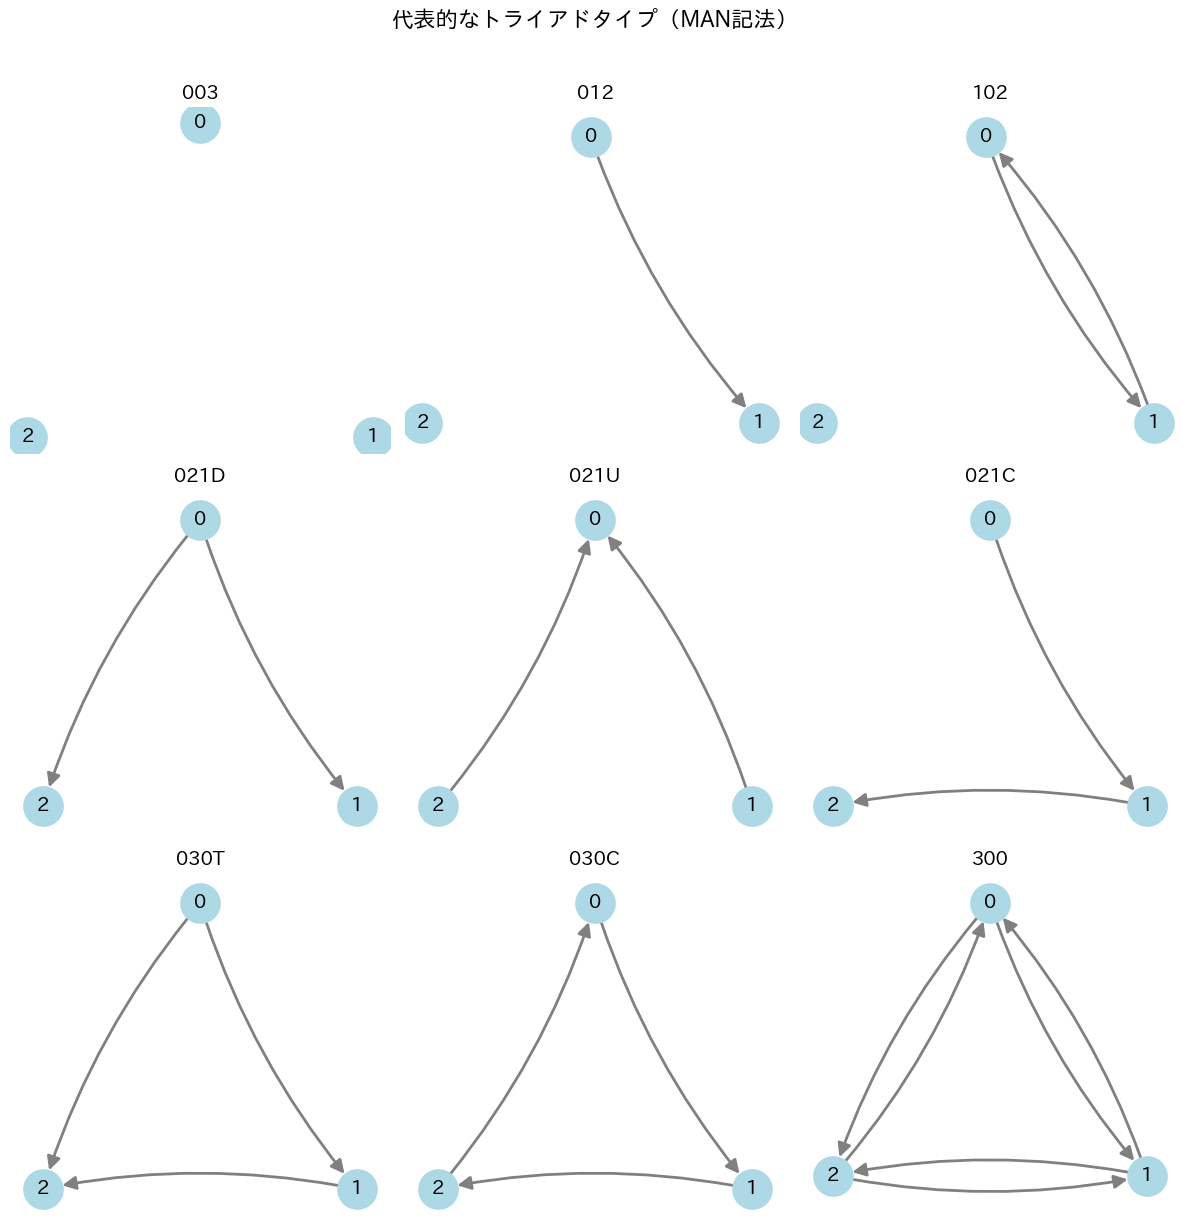

MAN記法の読み方:
  M: 相互エッジ（Mutual）の数
  A: 非対称エッジ（Asymmetric）の数
  N: 空のペア（Null）の数
  末尾の文字: D=Down, U=Up, C=Cyclic, T=Transitive


In [8]:
def visualize_triad_types():
    """
    代表的なトライアドタイプを可視化
    """
    triad_configs = {
        '003': [],  # 空
        '012': [(0, 1)],  # 1本のエッジ
        '102': [(0, 1), (1, 0)],  # 双方向1本
        '021D': [(0, 1), (0, 2)],  # 1点から2点へ
        '021U': [(1, 0), (2, 0)],  # 2点から1点へ
        '021C': [(0, 1), (1, 2)],  # チェーン
        '030T': [(0, 1), (0, 2), (1, 2)],  # 推移的
        '030C': [(0, 1), (1, 2), (2, 0)],  # サイクル
        '300': [(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1)],  # 完全双方向
    }
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    
    pos = {0: (0, 1), 1: (1, 0), 2: (-1, 0)}
    
    for ax, (name, edges) in zip(axes, triad_configs.items()):
        G = nx.DiGraph()
        G.add_nodes_from([0, 1, 2])
        G.add_edges_from(edges)
        
        nx.draw(G, pos, ax=ax, with_labels=True,
                node_color='lightblue', node_size=800, font_size=14,
                edge_color='gray', width=2,
                connectionstyle="arc3,rad=0.1",
                arrowsize=20)
        ax.set_title(f'{name}', fontsize=14)
    
    plt.suptitle('代表的なトライアドタイプ（MAN記法）', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("MAN記法の読み方:")
    print("  M: 相互エッジ（Mutual）の数")
    print("  A: 非対称エッジ（Asymmetric）の数")
    print("  N: 空のペア（Null）の数")
    print("  末尾の文字: D=Down, U=Up, C=Cyclic, T=Transitive")

visualize_triad_types()

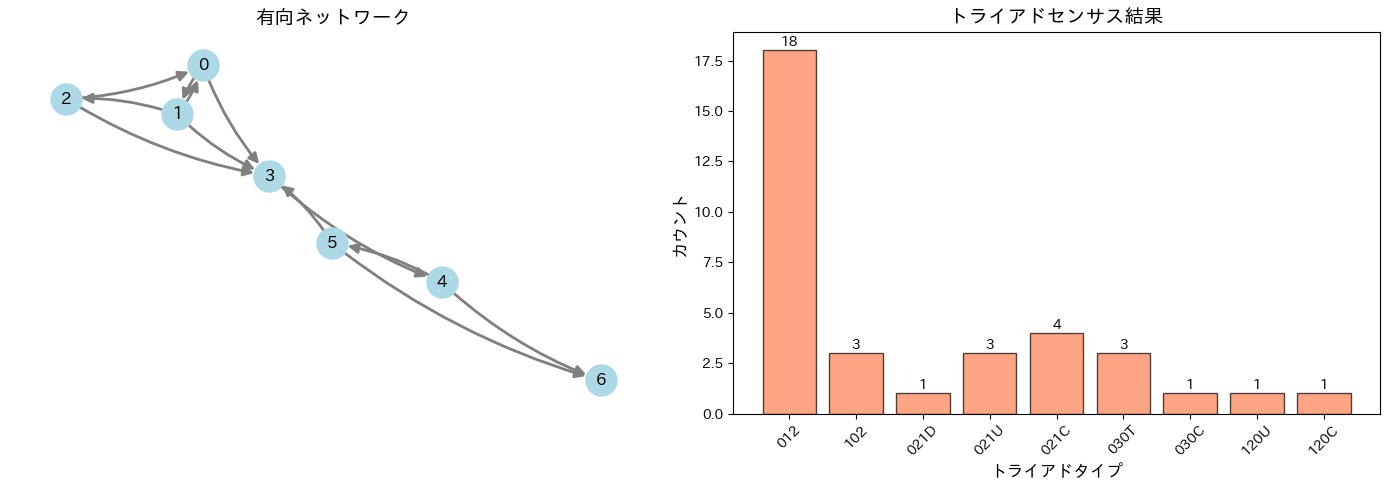

トライアドセンサス結果:
  012: 18
  021C: 4
  021D: 1
  021U: 3
  030C: 1
  030T: 3
  102: 3
  120C: 1
  120U: 1


In [9]:
# 実際のネットワークでトライアドセンサスを実行
# 小さな有向ネットワークを作成
G_directed = nx.DiGraph()
edges = [
    (0, 1), (1, 2), (2, 0),  # サイクル
    (0, 3), (1, 3), (2, 3),  # 3への収束
    (3, 4), (4, 5), (5, 3),  # 別のサイクル
    (4, 6), (5, 6),         # 6への収束
    (1, 0),                  # 双方向
]
G_directed.add_edges_from(edges)

# トライアドセンサス
census = nx.triadic_census(G_directed)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ネットワーク可視化
pos = nx.spring_layout(G_directed, seed=42)
nx.draw(G_directed, pos, ax=axes[0], with_labels=True,
        node_color='lightblue', node_size=500, font_size=12,
        edge_color='gray', width=2, arrowsize=15,
        connectionstyle="arc3,rad=0.1")
axes[0].set_title('有向ネットワーク', fontsize=14)

# トライアドセンサスの結果
# 非ゼロのトライアドタイプのみ表示
nonzero_census = {k: v for k, v in census.items() if v > 0}
types = list(nonzero_census.keys())
counts = list(nonzero_census.values())

bars = axes[1].bar(types, counts, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('トライアドタイプ', fontsize=12)
axes[1].set_ylabel('カウント', fontsize=12)
axes[1].set_title('トライアドセンサス結果', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

for bar, count in zip(bars, counts):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("トライアドセンサス結果:")
for triad_type, count in sorted(census.items()):
    if count > 0:
        print(f"  {triad_type}: {count}")

## A12.6 三者閉包と弱い紐帯

### トレードオフの関係

三者閉包は強い紐帯（ローカルな結束）を生み出しますが、弱い紐帯（橋渡し）を減らす傾向があります。

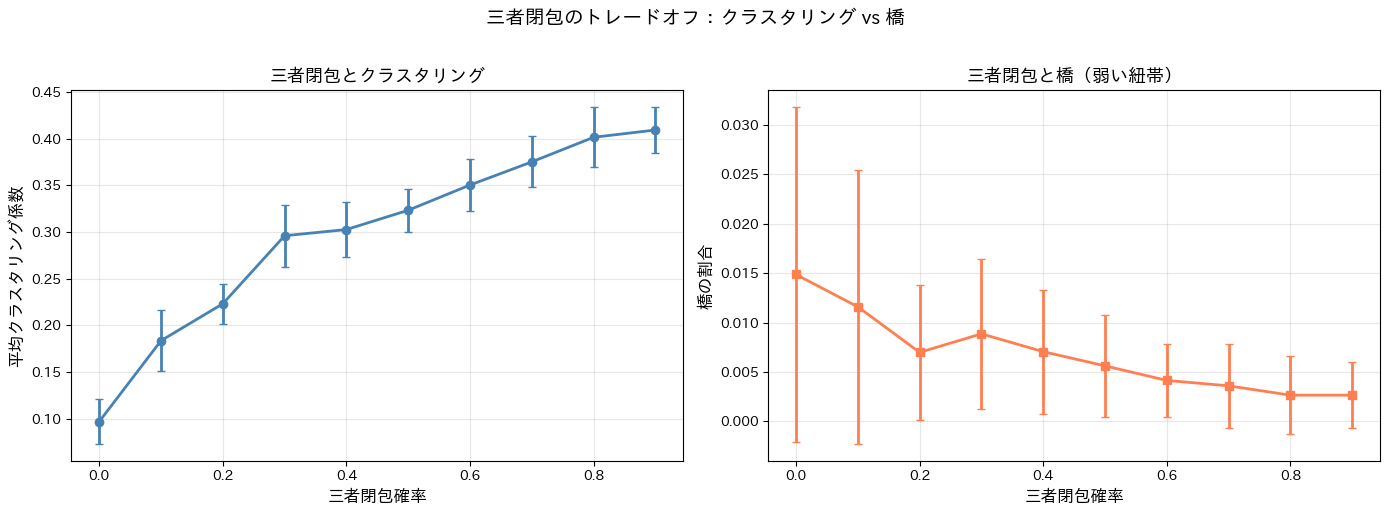

考察:
  三者閉包が増えると：
    - クラスタリング係数が上昇（ローカルな結束が強化）
    - 橋の割合が減少（弱い紐帯が失われる）
  
情報拡散への影響：
    - 高クラスタリング → 冗長な情報伝達
    - 少ない橋 → 異なるグループへの情報到達が困難


In [10]:
def analyze_closure_vs_bridges(n_steps=200, n_trials=10):
    """
    三者閉包と橋の関係を分析
    """
    p_closures = np.linspace(0, 0.9, 10)
    results = []
    
    for p_closure in p_closures:
        clustering_vals = []
        bridge_vals = []
        
        for trial in range(n_trials):
            G_init = nx.erdos_renyi_graph(50, 0.08, seed=trial)
            G_evolved, _ = evolve_with_triadic_closure(
                G_init, n_steps, p_closure=p_closure, p_random=0.1
            )
            
            clustering_vals.append(nx.average_clustering(G_evolved))
            
            # 橋の数を数える
            bridges = list(nx.bridges(G_evolved))
            bridge_vals.append(len(bridges) / G_evolved.number_of_edges() if G_evolved.number_of_edges() > 0 else 0)
        
        results.append({
            'p_closure': p_closure,
            'clustering_mean': np.mean(clustering_vals),
            'clustering_std': np.std(clustering_vals),
            'bridge_ratio_mean': np.mean(bridge_vals),
            'bridge_ratio_std': np.std(bridge_vals)
        })
    
    return results

results = analyze_closure_vs_bridges()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

p_values = [r['p_closure'] for r in results]

# クラスタリング係数
clustering_means = [r['clustering_mean'] for r in results]
clustering_stds = [r['clustering_std'] for r in results]
axes[0].errorbar(p_values, clustering_means, yerr=clustering_stds,
                 fmt='o-', capsize=3, color='steelblue', linewidth=2)
axes[0].set_xlabel('三者閉包確率', fontsize=12)
axes[0].set_ylabel('平均クラスタリング係数', fontsize=12)
axes[0].set_title('三者閉包とクラスタリング', fontsize=13)
axes[0].grid(True, alpha=0.3)

# 橋の割合
bridge_means = [r['bridge_ratio_mean'] for r in results]
bridge_stds = [r['bridge_ratio_std'] for r in results]
axes[1].errorbar(p_values, bridge_means, yerr=bridge_stds,
                 fmt='s-', capsize=3, color='coral', linewidth=2)
axes[1].set_xlabel('三者閉包確率', fontsize=12)
axes[1].set_ylabel('橋の割合', fontsize=12)
axes[1].set_title('三者閉包と橋（弱い紐帯）', fontsize=13)
axes[1].grid(True, alpha=0.3)

plt.suptitle('三者閉包のトレードオフ：クラスタリング vs 橋', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("考察:")
print("  三者閉包が増えると：")
print("    - クラスタリング係数が上昇（ローカルな結束が強化）")
print("    - 橋の割合が減少（弱い紐帯が失われる）")
print("  \n情報拡散への影響：")
print("    - 高クラスタリング → 冗長な情報伝達")
print("    - 少ない橋 → 異なるグループへの情報到達が困難")

## A12.7 リンク予測への応用

### 共通隣接ノード数に基づく予測

三者閉包の概念はリンク予測に応用できます。

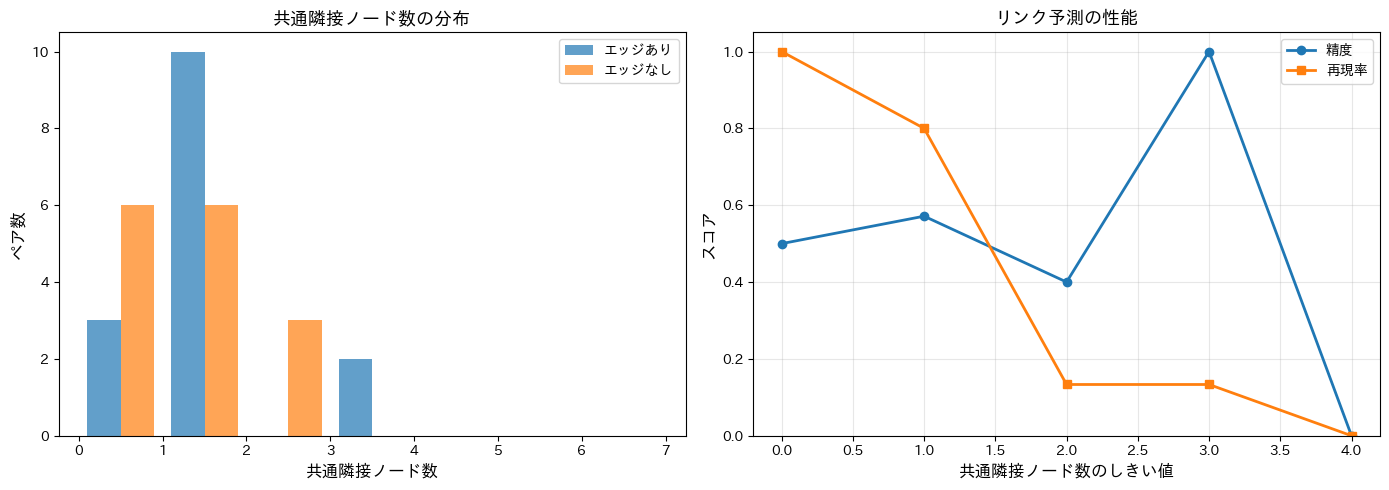

リンク予測の結果:
  テストエッジ数: 15
  ネガティブサンプル数: 15

共通隣接ノードに基づく予測:
  共通隣接ノードが多いほど、将来接続する可能性が高い


In [11]:
def link_prediction_common_neighbors(G, test_ratio=0.2):
    """
    共通隣接ノード数に基づくリンク予測
    """
    edges = list(G.edges())
    random.shuffle(edges)
    
    # テスト用にエッジを削除
    n_test = int(len(edges) * test_ratio)
    test_edges = edges[:n_test]
    train_edges = edges[n_test:]
    
    G_train = nx.Graph()
    G_train.add_nodes_from(G.nodes())
    G_train.add_edges_from(train_edges)
    
    # 共通隣接ノード数でスコアリング
    predictions = []
    
    for u, v in test_edges:
        if G_train.has_node(u) and G_train.has_node(v):
            common = len(set(G_train.neighbors(u)) & set(G_train.neighbors(v)))
            predictions.append((u, v, common, True))  # 実際にエッジあり
    
    # ネガティブサンプル（エッジがないペア）
    nodes = list(G.nodes())
    n_negative = len(predictions)
    negative_count = 0
    
    while negative_count < n_negative:
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v) and G_train.has_node(u) and G_train.has_node(v):
            common = len(set(G_train.neighbors(u)) & set(G_train.neighbors(v)))
            predictions.append((u, v, common, False))  # 実際にエッジなし
            negative_count += 1
    
    return predictions, G_train

# 空手クラブネットワークで実験
G = nx.karate_club_graph()
predictions, G_train = link_prediction_common_neighbors(G, test_ratio=0.2)

# スコア別の精度を計算
score_accuracy = defaultdict(lambda: {'correct': 0, 'total': 0})

for u, v, score, is_edge in predictions:
    predicted = score > 0  # 共通隣接ノードがあれば接続を予測
    if predicted == is_edge:
        score_accuracy[score]['correct'] += 1
    score_accuracy[score]['total'] += 1

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 共通隣接ノード数の分布
positive_scores = [p[2] for p in predictions if p[3]]
negative_scores = [p[2] for p in predictions if not p[3]]

axes[0].hist([positive_scores, negative_scores], bins=range(8), 
             label=['エッジあり', 'エッジなし'], alpha=0.7)
axes[0].set_xlabel('共通隣接ノード数', fontsize=12)
axes[0].set_ylabel('ペア数', fontsize=12)
axes[0].set_title('共通隣接ノード数の分布', fontsize=13)
axes[0].legend()

# しきい値別の精度
thresholds = range(0, 5)
precisions = []
recalls = []

for threshold in thresholds:
    tp = sum(1 for p in predictions if p[2] >= threshold and p[3])
    fp = sum(1 for p in predictions if p[2] >= threshold and not p[3])
    fn = sum(1 for p in predictions if p[2] < threshold and p[3])
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)

axes[1].plot(thresholds, precisions, 'o-', label='精度', linewidth=2)
axes[1].plot(thresholds, recalls, 's-', label='再現率', linewidth=2)
axes[1].set_xlabel('共通隣接ノード数のしきい値', fontsize=12)
axes[1].set_ylabel('スコア', fontsize=12)
axes[1].set_title('リンク予測の性能', fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

print("リンク予測の結果:")
print(f"  テストエッジ数: {len([p for p in predictions if p[3]])}")
print(f"  ネガティブサンプル数: {len([p for p in predictions if not p[3]])}")
print(f"\n共通隣接ノードに基づく予測:")
print("  共通隣接ノードが多いほど、将来接続する可能性が高い")

## A12.8 まとめ

### 三者閉包の主要概念

| 概念 | 説明 |
|------|------|
| 三者閉包 | 友達の友達は友達になりやすい傾向 |
| 開いたトライアド | 2本のエッジで結ばれた3ノード（三角形未完成） |
| 閉じたトライアド | 3本のエッジで結ばれた3ノード（三角形） |
| クラスタリング係数 | 隣接ノード間の接続密度 |
| 推移性 | ネットワーク全体での三角形の密度 |

### 三者閉包の影響

1. **ネットワーク構造**
   - クラスタリング係数の増加
   - コミュニティ構造の形成

2. **情報伝播**
   - ローカルでの冗長な情報伝達
   - 橋の減少による情報拡散の制限

3. **リンク予測**
   - 共通隣接ノード数が予測指標として有効

---

## 練習問題

### 問題1: クラスタリング係数の計算

以下のネットワークについて、各ノードのローカルクラスタリング係数を手計算で求め、NetworkXの結果と比較してください。

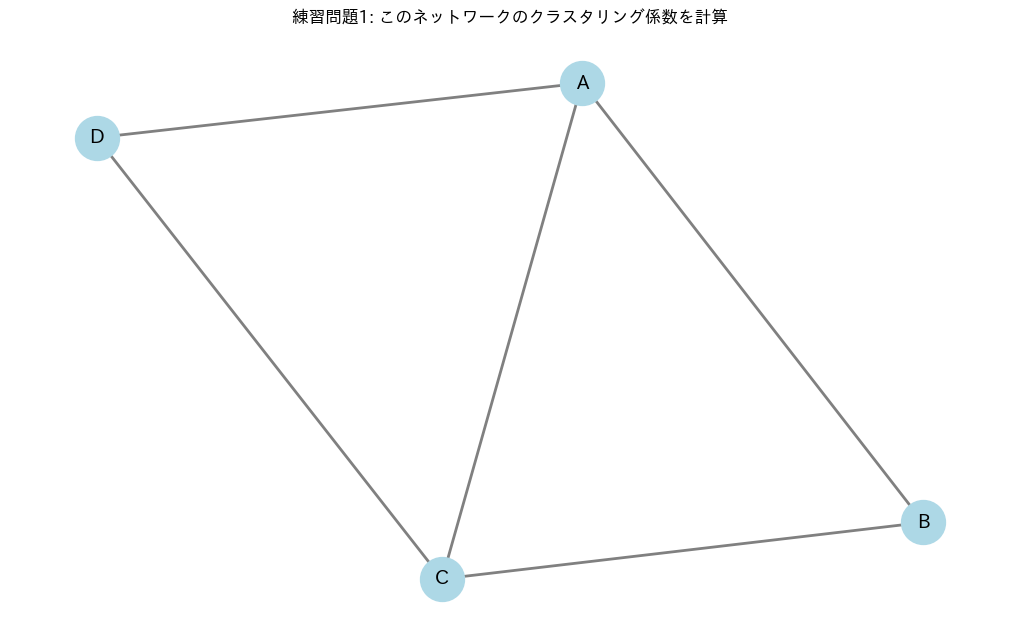

In [12]:
# ネットワークの定義
G_prob1 = nx.Graph()
G_prob1.add_edges_from([
    ('A', 'B'), ('A', 'C'), ('A', 'D'),
    ('B', 'C'), ('C', 'D')
])

# ネットワークを表示
pos = nx.spring_layout(G_prob1, seed=42)
nx.draw(G_prob1, pos, with_labels=True, node_color='lightblue',
        node_size=1000, font_size=14, edge_color='gray', width=2)
plt.title('練習問題1: このネットワークのクラスタリング係数を計算')
plt.show()

# ここにコードを書いてください


<details>
<summary>解答例を見る</summary>

```python
# 手計算
print("手計算:")
print("  ノードA: 次数=3, 隣接ノード={B,C,D}")
print("    隣接ノード間のエッジ: B-C, C-D (2本)")
print("    可能なエッジ数: 3*2/2 = 3")
print("    C_A = 2/3 = 0.667")

print("\n  ノードB: 次数=2, 隣接ノード={A,C}")
print("    隣接ノード間のエッジ: A-C (1本)")
print("    可能なエッジ数: 2*1/2 = 1")
print("    C_B = 1/1 = 1.0")

print("\n  ノードC: 次数=3, 隣接ノード={A,B,D}")
print("    隣接ノード間のエッジ: A-B, A-D (2本)")
print("    可能なエッジ数: 3*2/2 = 3")
print("    C_C = 2/3 = 0.667")

print("\n  ノードD: 次数=2, 隣接ノード={A,C}")
print("    隣接ノード間のエッジ: A-C (1本)")
print("    可能なエッジ数: 2*1/2 = 1")
print("    C_D = 1/1 = 1.0")

# NetworkXで検証
print("\nNetworkXの結果:")
for node, coef in nx.clustering(G_prob1).items():
    print(f"  C_{node} = {coef:.3f}")

print(f"\n平均クラスタリング係数: {nx.average_clustering(G_prob1):.3f}")
print(f"推移性: {nx.transitivity(G_prob1):.3f}")
```
</details>

### 問題2: 三者閉包の検出

与えられたネットワークから、すべての開いたトライアドを検出し、それぞれの中心ノードを特定してください。
また、最も多くの開いたトライアドの中心となっているノードを見つけてください。

In [13]:
# テスト用ネットワーク
G_prob2 = nx.karate_club_graph()

# ここにコードを書いてください


<details>
<summary>解答例を見る</summary>

```python
def find_open_triads_by_center(G):
    """中心ノードごとの開いたトライアドを検出"""
    center_counts = defaultdict(int)
    open_triads = []
    
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                if not G.has_edge(n1, n2):
                    center_counts[node] += 1
                    open_triads.append((node, n1, n2))
    
    return center_counts, open_triads

center_counts, open_triads = find_open_triads_by_center(G_prob2)

print(f"開いたトライアドの総数: {len(open_triads)}")
print(f"\n中心ノードごとのカウント（上位10）:")
sorted_centers = sorted(center_counts.items(), key=lambda x: x[1], reverse=True)
for node, count in sorted_centers[:10]:
    print(f"  ノード {node}: {count} 個")

# 最も多くの開いたトライアドの中心となっているノード
max_center = sorted_centers[0]
print(f"\n最も多くの開いたトライアドの中心: ノード {max_center[0]} ({max_center[1]}個)")

# 可視化
fig, ax = plt.subplots(figsize=(10, 8))
pos = nx.spring_layout(G_prob2, seed=42)

# ノードの色を中心カウントに基づいて設定
node_colors = [center_counts.get(n, 0) for n in G_prob2.nodes()]
nodes = nx.draw_networkx_nodes(G_prob2, pos, ax=ax, node_color=node_colors,
                                cmap=plt.cm.Reds, node_size=300)
nx.draw_networkx_edges(G_prob2, pos, ax=ax, edge_color='gray', alpha=0.5)
nx.draw_networkx_labels(G_prob2, pos, ax=ax, font_size=8)

plt.colorbar(nodes, label='開いたトライアドの中心回数')
plt.title('開いたトライアドの中心ノード')
plt.show()
```
</details>

### 問題3: ネットワーク進化の比較

以下の2つのネットワーク進化モデルを比較してください：
1. 三者閉包のみ（p_closure=0.8, p_random=0）
2. ランダム接続のみ（p_closure=0, p_random=0.8）

200ステップ後のネットワーク特性（クラスタリング係数、平均経路長、次数分布）を比較してください。

In [14]:
# ここにコードを書いてください


<details>
<summary>解答例を見る</summary>

```python
# 初期ネットワーク
G_init = nx.erdos_renyi_graph(50, 0.08, seed=42)

# 2つのモデルで進化
G_closure, hist_closure = evolve_with_triadic_closure(
    G_init.copy(), n_steps=200, p_closure=0.8, p_random=0
)
G_random, hist_random = evolve_with_triadic_closure(
    G_init.copy(), n_steps=200, p_closure=0, p_random=0.8
)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# ネットワーク構造
pos_c = nx.spring_layout(G_closure, seed=42)
nx.draw(G_closure, pos_c, ax=axes[0, 0], node_size=30,
        node_color='steelblue', edge_color='gray', alpha=0.7, width=0.3)
axes[0, 0].set_title(f'三者閉包モデル\nC={nx.average_clustering(G_closure):.3f}', fontsize=12)

pos_r = nx.spring_layout(G_random, seed=42)
nx.draw(G_random, pos_r, ax=axes[0, 1], node_size=30,
        node_color='coral', edge_color='gray', alpha=0.7, width=0.3)
axes[0, 1].set_title(f'ランダムモデル\nC={nx.average_clustering(G_random):.3f}', fontsize=12)

# クラスタリング係数の比較
axes[0, 2].hist([list(nx.clustering(G_closure).values()),
                  list(nx.clustering(G_random).values())],
                 bins=20, label=['三者閉包', 'ランダム'], alpha=0.7)
axes[0, 2].set_xlabel('クラスタリング係数')
axes[0, 2].set_ylabel('ノード数')
axes[0, 2].set_title('クラスタリング係数の分布')
axes[0, 2].legend()

# 次数分布
degrees_c = [d for n, d in G_closure.degree()]
degrees_r = [d for n, d in G_random.degree()]
axes[1, 0].hist([degrees_c, degrees_r], bins=15,
                 label=['三者閉包', 'ランダム'], alpha=0.7)
axes[1, 0].set_xlabel('次数')
axes[1, 0].set_ylabel('ノード数')
axes[1, 0].set_title('次数分布')
axes[1, 0].legend()

# 進化過程の比較
axes[1, 1].plot(hist_closure['clustering'], label='三者閉包', linewidth=2)
axes[1, 1].plot(hist_random['clustering'], label='ランダム', linewidth=2)
axes[1, 1].set_xlabel('ステップ')
axes[1, 1].set_ylabel('クラスタリング係数')
axes[1, 1].set_title('クラスタリング係数の進化')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 統計比較
stats = {
    '指標': ['エッジ数', '三角形数', 'クラスタリング係数', '推移性'],
    '三者閉包': [
        G_closure.number_of_edges(),
        sum(nx.triangles(G_closure).values()) // 3,
        f"{nx.average_clustering(G_closure):.3f}",
        f"{nx.transitivity(G_closure):.3f}"
    ],
    'ランダム': [
        G_random.number_of_edges(),
        sum(nx.triangles(G_random).values()) // 3,
        f"{nx.average_clustering(G_random):.3f}",
        f"{nx.transitivity(G_random):.3f}"
    ]
}

axes[1, 2].axis('off')
table = axes[1, 2].table(
    cellText=[[stats['指標'][i], stats['三者閉包'][i], stats['ランダム'][i]] 
              for i in range(len(stats['指標']))],
    colLabels=['指標', '三者閉包', 'ランダム'],
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)
axes[1, 2].set_title('統計比較', fontsize=12, y=0.8)

plt.tight_layout()
plt.show()

print("考察:")
print("  三者閉包モデル: 高いクラスタリング、密なコミュニティ構造")
print("  ランダムモデル: 低いクラスタリング、均一なネットワーク構造")
```
</details>

---

## 参考文献

1. Rapoport, A. (1953). Spread of information through a population with socio-structural bias. Bulletin of Mathematical Biophysics, 15(4), 523-543.

2. Watts, D. J., & Strogatz, S. H. (1998). Collective dynamics of 'small-world' networks. Nature, 393(6684), 440-442.

3. Easley, D., & Kleinberg, J. (2010). Networks, Crowds, and Markets. Cambridge University Press. Chapter 3.

4. Holland, P. W., & Leinhardt, S. (1976). Local structure in social networks. Sociological Methodology, 7, 1-45.